# openEO use case for floods - UC11

## GFM

The Global Flood Monitoring (GFM) product is a component of the EU’s Copernicus
Emergency Management Service (CEMS) that provides continuous monitoring of
floods worldwide, by processing and analysing in near real-time all
incoming Sentinel-1 SAR acquisitions over land.

The operational implementation the GFM product includes the following key
elements:
- Downloading of worldwide Sentinel-1 SAR acquisitions (Level-1 IW GRDH)
- Pre-processing of the downloaded Sentinel-1 data to backscatter data (SIG0)
- Operational application of three fully automated flood mapping algorithms.
- An ensemble-based approach is then used to combine the three flood extent
  outputs of the individual flood algorithms.
- Generation of the required GFM output layers, including Observed flood extent,
  Reference water mask, Exclusion Mask and Likelihood Values
- Web service-based access and dissemination of the GFM product output layers

### Output layers used in this notebook
- Observed flood extent (ENSEMBLE of all three individual flood outputs)
- Reference water mask (permament and seasonal water bodies)

### Links
https://extwiki.eodc.eu/GFM

### Connect and authenticate to openEO

In [1]:
import openeo
from openeo.processes import *

backend = "openeo.cloud"
conn = openeo.connect(backend)
conn = conn.authenticate_oidc()

Authenticated using refresh token.


### Describe the GFM collection

In [2]:
conn.describe_collection("GFM")

{'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['flood_extent', 'refwater']},
  'time': {'extent': [['2015-01-01T00:00:00Z', None]], 'type': 'temporal'},
  'x': {'axis': 'x', 'extent': [-180, 180], 'type': 'spatial'},
  'y': {'axis': 'y', 'extent': [-90, 90], 'type': 'spatial'}},
 'description': "The Global Flood Monitoring (GFM) product is a new component of the EU's Copernicus Emergency Management Service (CEMS) that provides continuous monitoring of floods worldwide, by processing and analysing in near real-time (NRT) all incoming Synthetic Aperture Radar (SAR) imagery acquired by the EU's Copernicus Sentinel-1 satellites, in Interferometric Wide Swath (IW) mode and as Ground Range Detected (GRD) products.",
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2015-01-01T00:00:00Z', None]]}},
 'id': 'GFM',
 'license': 'proprietary',
 'links': [{'href': 'https://dev.stac.eodc.eu/api/v1/collections/GFM/items',
   'rel': 'items',
   'type': 'application/geo+json'},
  {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections',
   'rel': 'root'},
  {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections',
   'rel': 'parent'},
  {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections/GFM',
   'rel': 'self'}],
 'providers': [{'name': 'JRC CEMS',
   'roles': ['licensor'],
   'url': 'https://emergency.copernicus.eu/'},
  {'name': 'EODC', 'roles': ['processor', 'host'], 'url': 'https://eodc.eu/'}],
 'stac_extensions': ['https://stac-extensions.github.io/projection/v1.1.0/schema.json',
  'https://stac-extensions.github.io/eo/v1.1.0/schema.json',
  'https://stac-extensions.github.io/datacube/v2.2.0/schema.json',
  'https://stac-extensions.github.io/eo/v1.1.0/schema.json'],
 'stac_version': '1.0.0',
 'summaries': {'constellation': ['sentinel-1'],
  'eo:bands': [{'description': 'GFM observed flood extent',
    'name': 'flood_extent'},
   {'description': 'GFM reference water mask', 'name': 'refwater'}],
  'federation:backends': ['eodc'],
  'platform': ['sentinel-1a', 'sentinel-1b']},
 'title': 'Global Flood Monitoring',
 'type': 'Collection'}

### Sum of flooded_pixel over time

In [3]:
spatial_extent  = {'west': 67.5, 'east': 70, 'south': 24.5, 'north': 26}
temporal_extent = ["2022-09-01", "2022-10-01"] 
collection      = 'GFM'

gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["flood_extent"]
)
gfm_sum = gfm_data.reduce_dimension(dimension="time", reducer=sum)

gfm_sum_tiff = gfm_sum.save_result(format="GTiff", options={"tile_grid": "wgs84-1degree"})

In [4]:
job = gfm_sum_tiff.create_job(title = "UC11")
jobId = job.job_id
job.start_job()

<BatchJob job_id='eodc-5913a8c3-a624-47c6-92ba-0a1fc067ed4a'>

In [6]:
job.status()

'running'

In [10]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./gfm/flood_extent/")

[PosixPath('gfm/flood_extent/WGS84_E67N23_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E67N24_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E67N25_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E67N26_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E68N23_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E68N24_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E68N25_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E68N26_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E69N23_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E69N24_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E69N25_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E69N26_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E70N23_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E70N24_20220901T010907.tif'),
 PosixPath('gfm/flood_extent/WGS84_E70N25_20220901T010907.tif'),
 PosixPath('gfm/flood_ext

### Load the downloaded result files

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

path = "./gfm/flood_extent/"
files = [path + file for file in os.listdir(path) if file.startswith("WGS84") and file.endswith(".tif")]
D = xr.open_mfdataset(files)
d = D.band_data.sel(band=1)

### Explore how the flood extent relates to the Global Human Settlement Layer 

The Global Human Settlement Layer (GHSL) project produces global spatial information about the human presence on the planet over time in the form of built-up maps, population density maps and settlement maps.

https://ghsl.jrc.ec.europa.eu/about.php

In [ ]:
import s3fs
import xarray as xr
S3_URL_CENTRAL = "https://s3.central.data.destination-earth.eu"
s3_central = s3fs.S3FileSystem(
    anon=True,
    use_ssl=True,
    client_kwargs={"endpoint_url": S3_URL_CENTRAL},
)
ghsl = xr.open_zarr(store=s3fs.S3Map(
    root="increment1-testdata/built_data.zarr", 
    s3=s3_central, 
    check=False),
    decode_coords="all"
)
display(ghsl)

min_lat, max_lat = 25.1, 25.2
min_lon, max_lon = 69.1, 69.2

ghsl_im = ghsl.built.sel(x=slice(min_lon, max_lon), y=slice(max_lat, min_lat))

In [14]:
ghsl = xr.open_dataset("./../ghsl.nc")
display(ghsl)

<xarray.Dataset>
Dimensions:      (x: 1251, y: 1251)
Coordinates:
    band         int64 ...
  * x            (x) float64 69.1 69.1 69.1 69.1 69.1 ... 69.2 69.2 69.2 69.2
  * y            (y) float64 25.2 25.2 25.2 25.2 25.2 ... 25.1 25.1 25.1 25.1
Data variables:
    spatial_ref  int64 ...
    built        (y, x) float32 ...

In [15]:
min_lat, max_lat = np.min(ghsl.y.values), np.max(ghsl.y.values)
min_lon, max_lon = np.min(ghsl.x.values), np.max(ghsl.x.values)

flood_extent = d.sel(x=slice(min_lon, max_lon), y=slice(max_lat, min_lat))
flood_extent = xr.where(flood_extent == 0, np.nan, flood_extent)
display(flood_extent)

<xarray.DataArray 'band_data' (y: 556, x: 555)>
dask.array<where, shape=(556, 555), dtype=float32, chunksize=(556, 555), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 69.1 69.1 69.1 69.1 69.1 ... 69.2 69.2 69.2 69.2
  * y            (y) float64 25.2 25.2 25.2 25.2 25.2 ... 25.1 25.1 25.1 25.1
    spatial_ref  int64 0

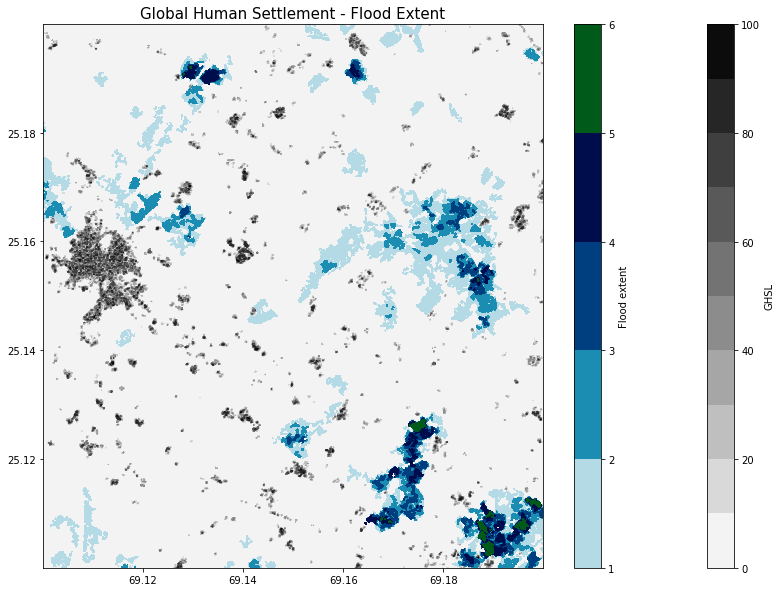

In [16]:
plt.figure(figsize=(14,10))
plt.title("Global Human Settlement - Flood Extent", fontsize=15)
X, Y = np.meshgrid(ghsl.x.values, ghsl.y.values)
g = plt.contourf(X, Y, ghsl.built,cmap='gray_r', levels=10)
plt.colorbar(label="GHSL")
X, Y = np.meshgrid(flood_extent.x.values, flood_extent.y.values)
f = plt.contourf(X, Y, flood_extent,cmap='ocean_r', levels=5)
plt.colorbar(label="Flood extent")

### Observed water (flood_extent + refwater)

The observed water combines both flood extent and the reference water mask. The reference water mask represents permanent or seasonal water bodies, which are clearly distinct from flood events.

In [17]:
spatial_extent  = {'west': 67.5, 'east': 70, 'south': 24.5, 'north': 26}
temporal_extent = ["2022-09-01", "2022-10-01"] 
collection      = 'GFM'

gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["flood_extent", "refwater"]
)

# retrieve all pixels which have been detected as water during the given period
# -> observed water
observed_water = gfm_data.reduce_dimension(dimension="bands", reducer=any).reduce_dimension(dimension="time", reducer=any)

# Save the result in Equi7Grid and as GeoTiff
observed_water_tif = observed_water.save_result(format="GTiff", options={"tile_grid": "equi7", "dtype": "bool"})

In [18]:
job = observed_water_tif.create_job(title = "UC11")
jobId = job.job_id
job.start_job()

<BatchJob job_id='eodc-aa0c4aa1-7bbe-45d4-98d9-b004f008df41'>

In [38]:
job.status()

'finished'

In [39]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./gfm/observed_water/")

[PosixPath('gfm/observed_water/AS020M_E015N024T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/AS020M_E015N027T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/AS020M_E018N024T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/AS020M_E018N027T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/job-results.json')]

In [19]:
path = "./gfm/observed_water/"
files = [path + file for file in os.listdir(path) if file.startswith("AS") and file.endswith(".tif")]
# we expect only 0 and 1 -> bool
data = xr.open_mfdataset(files).astype("bool")
d = data.band_data
display(d)

<xarray.DataArray 'band_data' (band: 1, y: 11879, x: 14489)>
dask.array<astype, shape=(1, 11879, 14489), dtype=bool, chunksize=(1, 9506, 8967), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.621e+06 1.621e+06 1.621e+06 ... 1.91e+06 1.91e+06
  * y            (y) float64 2.89e+06 2.89e+06 2.89e+06 ... 2.653e+06 2.653e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:                 Area
    filepaths:                     None
    snapshot_STAC_collection_URL:  https://dev.stac.eodc.eu/api/v1/collection...

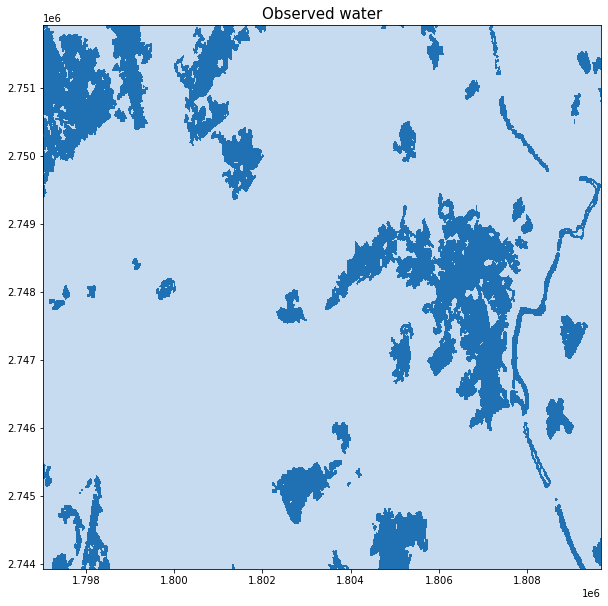

In [27]:
plt.figure(figsize=(10,10))
plt.title("Observed water", fontsize=15)
d_small = d.sel(band=1, x=slice(1797025,1809688), y=slice(2751932,2743913))
X, Y = np.meshgrid(d_small.x.values, d_small.y.values)
plt.contourf(X, Y, d_small,cmap='Blues')